In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import numpy as np

In [2]:
# データの生成
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]

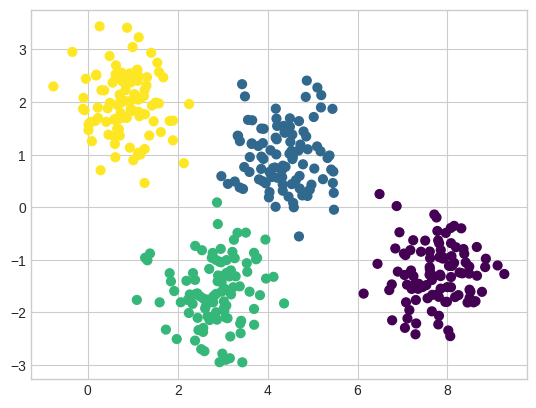

In [3]:
# k平均法でラベルを推定して表示する
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis")

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

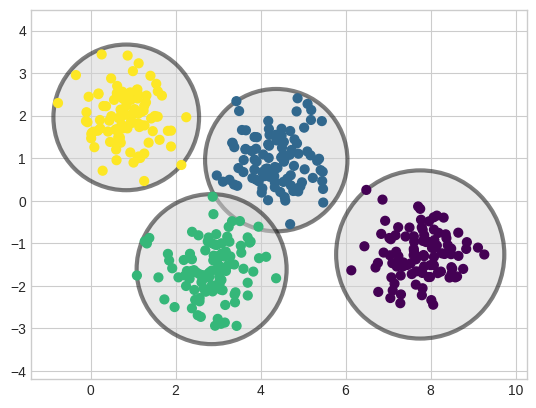

In [5]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # 入力データのプロット
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)

    # k平均法モデルのプロット
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]

    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, ec='black', fc='lightgray', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

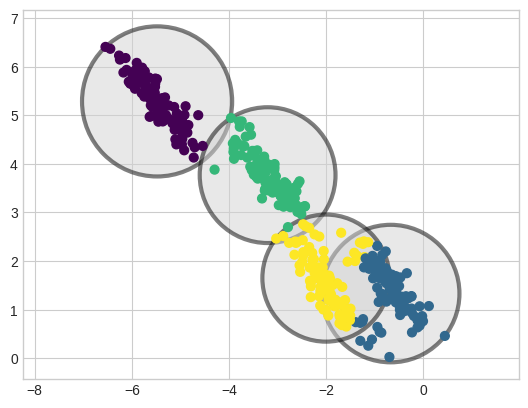

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

## 混合ガウスモデル

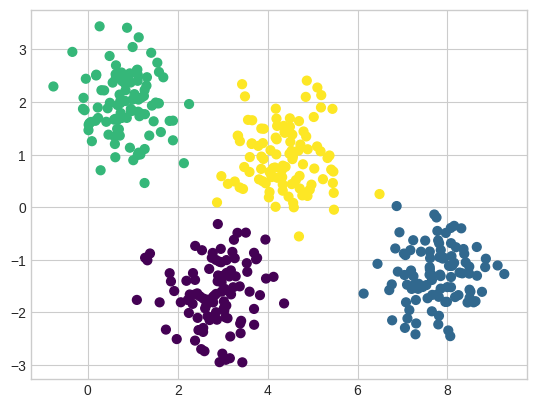

In [8]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis")

In [9]:
# 確率的なクラスタ割り当て
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


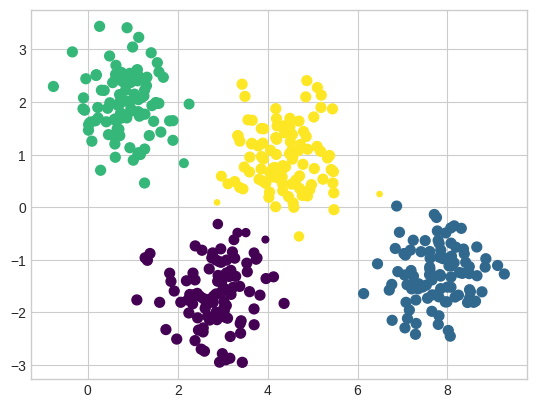

In [10]:
# 確率をマーカーの大きさに反映して描画
size = 50 * probs.max(1) ** 2
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=size)

In [16]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """指定した位置と共分散から円を描画する関数"""
    ax = ax or plt.gca()

    # 共分散を主軸に変換する
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # 楕円の描画
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig*width, nsig*height, angle=angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)

    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)

    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)

    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()

    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

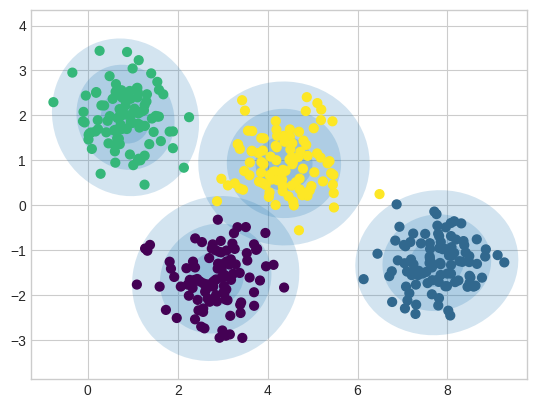

In [17]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

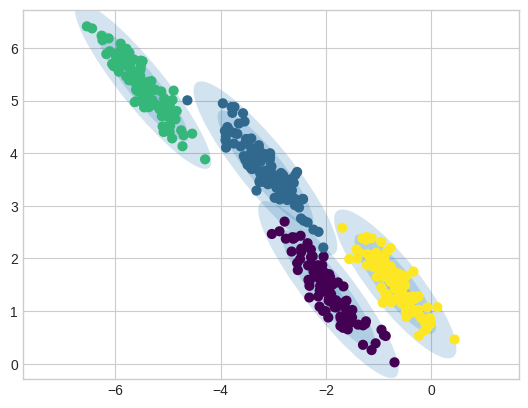

In [19]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

## 混合ガウスモデルによる密度推定

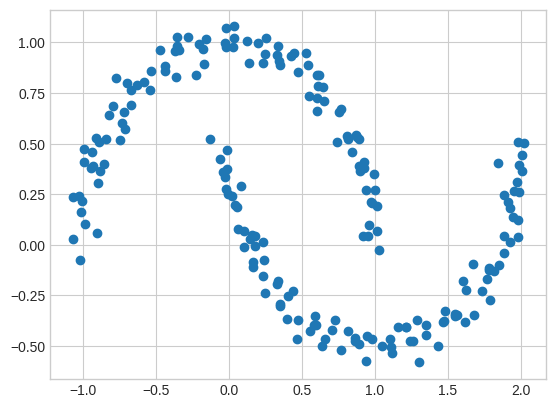

In [22]:
from sklearn.datasets import make_moons

# 非線形境界を持つデータセットの準備
Xmoon, ymonn = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

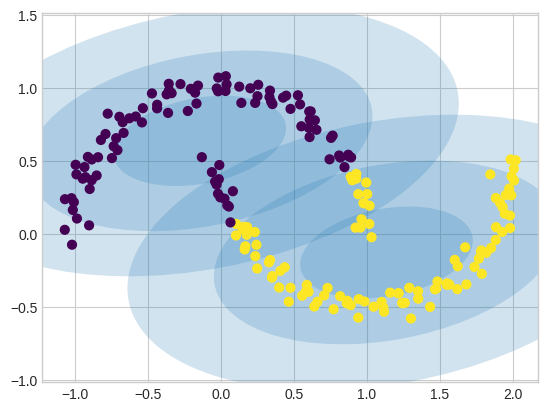

In [23]:
# 2成分GMM
gmm2 = GaussianMixture(n_components=2, covariance_type="full", random_state=0)
plot_gmm(gmm2, Xmoon)

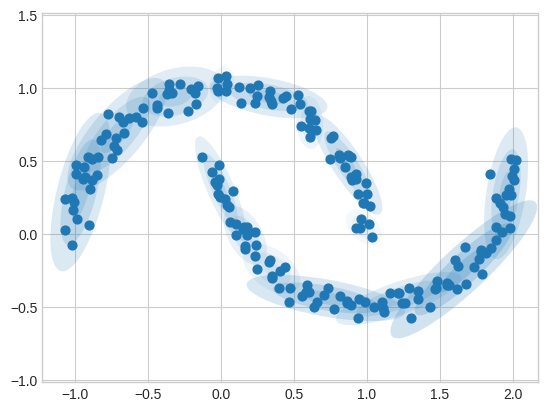

In [26]:
# 多成分GMM：入力データの分布のモデル化
gmm16 = GaussianMixture(n_components=16, covariance_type="full", random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

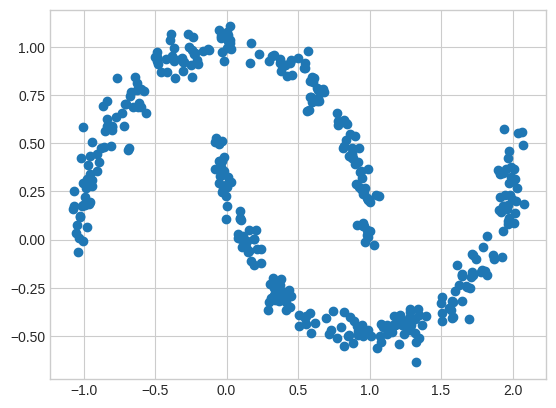

In [28]:
# 多成分GMMによる入力データと同じ分布の生成
Xnew, ynew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

Text(0.5, 0, 'n_components')

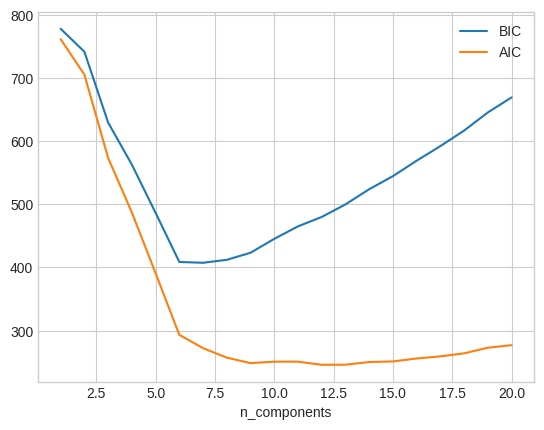

In [29]:
# 各成分GMMのBIC(米巣情報量基準)とAIC(赤池情報量基準)の可視化
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')